# Predicting Repeat Buyers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn import metrics

%matplotlib inline

/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
train = pd.read_csv("trainHistory.csv", parse_dates =['offerdate'])
test= pd.read_csv("testHistory.csv",parse_dates =['offerdate'])
offer = pd.read_csv("offers.csv")

In [ ]:
# Data Reduction Script used from Triskelion 
transactions = pd.read_csv("../transactions/reduced2.csv",parse_dates =['date'])

In [8]:
transactions = pd.read_csv("../transactions/transactions.csv",parse_dates =['date'])

## Preprocessing Data

In [9]:
#Merge train and test set with offer and create additional date features
def preprocessing(x):
    
    x = pd.merge(x,offer,left_on='offer',right_on='offer',how='left')
    
    x['year'] = x.offerdate.apply(lambda n: n.year)
    x['month'] = x.offerdate.apply(lambda n: n.month)
    x['week'] = x.offerdate.apply(lambda n: n.week)
    x['dayofweek'] = x.offerdate.apply(lambda n: n.dayofweek)
    return x

In [10]:
test = preprocessing(test)
train = preprocessing(train)

In [11]:
x = train[['id','offerdate']]
y = test[['id','offerdate']]
z = pd.concat([x,y])
transactions = pd.merge(transactions,z,left_on='id',right_on='id',how='left')
transactions['date_difference'] = transactions.offerdate - transactions.date

In [12]:
transactions.head()

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount,offerdate,date_difference
0,86246,205,7,707,1078778070,12564,2012-03-02,12,OZ,1,7.59,2013-04-24,418 days
1,86246,205,63,6319,107654575,17876,2012-03-02,64,OZ,1,1.59,2013-04-24,418 days
2,86246,205,97,9753,1022027929,0,2012-03-02,1,CT,1,5.99,2013-04-24,418 days
3,86246,205,25,2509,107996777,31373,2012-03-02,16,OZ,1,1.99,2013-04-24,418 days
4,86246,205,55,5555,107684070,32094,2012-03-02,16,OZ,2,10.38,2013-04-24,418 days


In [13]:
#How many times bought from a Category, Company, brand and chain
for n in ['category','company','brand','chain']:
    x = transactions.groupby(['id',n]).size()
    x = pd.DataFrame(x).reset_index()
    x.columns = ['id', n, n+'_frequency_bought']
    train = pd.merge(train,x,left_on=['id',n],right_on=['id',n],how='left')
    test = pd.merge(test,x,left_on=['id',n],right_on=['id',n],how='left')

In [14]:
#Whether or not they have purchased from the category,company,brand and chain
for n in ['category','company','brand','chain']:
    
    train['has_bought_'+n] = train[n+'_frequency_bought'].apply(lambda x: 1 if x >= 1 else 0)
    test['has_bought_'+n] = test[n+'_frequency_bought'].apply(lambda x: 1 if x >= 1 else 0)

In [16]:
#Total spent by customer
x = transactions.groupby('id').purchaseamount.sum()
x = pd.DataFrame(x).reset_index()
x.columns = ['id','Total_Spent']
train = pd.merge(train,x,left_on=['id'],right_on=['id'],how='left')
test = pd.merge(test,x,left_on=['id'],right_on=['id'],how='left')

In [17]:
#How much quantity from a Category, Company, brand and chain
for n in ['category','company','brand','chain']:
    x = transactions.groupby(['id',n]).purchasequantity.sum()
    x = pd.DataFrame(x).reset_index()
    x.columns = ['id', n, n+'_quantity_bought']
    train = pd.merge(train,x,left_on=['id',n],right_on=['id',n],how='left')
    test = pd.merge(test,x,left_on=['id',n],right_on=['id',n],how='left')

In [18]:
#Total Dollar Value bought from category, company,brand and chain
for n in ['category','company','brand','chain']:
    x = transactions.groupby(['id',n]).purchaseamount.sum()
    x = pd.DataFrame(x).reset_index()
    x.columns = ['id',n,n + '_dollars_spent']
    train = pd.merge(train,x,left_on=['id',n],right_on=['id',n],how='left')
    test = pd.merge(test,x,left_on=['id',n],right_on=['id',n],how='left')

In [19]:
# Number of purchases from combined category + company + brand + chain
x = transactions.groupby(['id','category','company','brand','chain']).size()
x = pd.DataFrame(x).reset_index()
x.columns = ['id','category','company','brand','chain', 'All_quantity_bought']
train = pd.merge(train,x,left_on=['id','category','company','brand','chain'],right_on=['id','category','company','brand','chain'],how='left')
test = pd.merge(test,x,left_on=['id','category','company','brand','chain'],right_on=['id','category','company','brand','chain'],how='left')

In [20]:
# Dollar Amount from combined category + company + brand + chain
x = transactions.groupby(['id','category','company','brand','chain']).purchaseamount.sum()
x = pd.DataFrame(x).reset_index()
x.columns = ['id','category','company','brand','chain', 'All_dollar_spent']
train = pd.merge(train,x,left_on=['id','category','company','brand','chain'],right_on=['id','category','company','brand','chain'],how='left')
test = pd.merge(test,x,left_on=['id','category','company','brand','chain'],right_on=['id','category','company','brand','chain'],how='left')

In [21]:
#Time Segements how frequency,quantity and amount purchased in last 30,60,90,180 days
for n in ['category','company','brand','chain']:
    
    for z in ['30','60','90','180']:
        
        x = transactions[transactions.date_difference < z + ' days'].groupby(['id',n]).size()
        x = pd.DataFrame(x).reset_index()
        x.columns = ['id',n,n +'_frequency_bought_'+ z]
        train = pd.merge(train,x,left_on=['id',n],right_on=['id',n],how='left')
        test = pd.merge(test,x,left_on=['id',n],right_on=['id',n],how='left')
        
        x = transactions[transactions.date_difference < z + ' days'].groupby(['id',n]).agg({'purchasequantity': np.sum,'purchaseamount':np.sum})
        x = pd.DataFrame(x).reset_index()
        x.columns = ['id',n,n +'_dollars_spent_'+ z,n +'_quantity_bought_'+ z]
        train = pd.merge(train,x,left_on=['id',n],right_on=['id',n],how='left')
        test = pd.merge(test,x,left_on=['id',n],right_on=['id',n],how='left')

In [22]:
train.head()

,id,chain,offer,market,repeattrips,repeater,offerdate,category,quantity,company,...,chain_quantity_bought_30,chain_frequency_bought_60,chain_dollars_spent_60,chain_quantity_bought_60,chain_frequency_bought_90,chain_dollars_spent_90,chain_quantity_bought_90,chain_frequency_bought_180,chain_dollars_spent_180,chain_quantity_bought_180
0,86246,205,1208251,34,5,t,2013-04-24,2202,1,104460040,...,5725,7639,31692.22,10881,8036,33573.51,11420,8922,37321.05,12540
1,86252,205,1197502,34,16,t,2013-03-27,3203,1,106414464,...,10137,6756,31237.42,10667,7129,32784.22,11186,8743,39491.70,13298
2,12682470,18,1197502,11,0,f,2013-03-28,3203,1,106414464,...,43,86,391.26,110,187,775.38,231,429,1837.88,533
3,12996040,15,1197502,9,0,f,2013-03-25,3203,1,106414464,...,25,59,278.97,67,79,354.11,92,151,724.63,178
4,13089312,15,1204821,9,0,f,2013-04-01,5619,1,107717272,...,157,213,646.21,264,284,838.40,344,551,1566.45,667


In [23]:
test.head()

,id,chain,offer,market,offerdate,category,quantity,company,offervalue,brand,...,chain_quantity_bought_30,chain_frequency_bought_60,chain_dollars_spent_60,chain_quantity_bought_60,chain_frequency_bought_90,chain_dollars_spent_90,chain_quantity_bought_90,chain_frequency_bought_180,chain_dollars_spent_180,chain_quantity_bought_180
0,12262064,95,1219903,39,2013-06-27,799,1,1076211171,1.5,17286,...,125,179,551.76,205,232,699.70,260,317,1023.30,358
1,12277270,95,1221658,39,2013-06-23,7205,2,103700030,3.0,4294,...,109,139,812.26,177,195,1167.37,243,472,3063.53,594
2,12332190,95,1213242,39,2013-06-15,5824,1,105190050,2.0,26456,...,18,48,155.18,64,85,303.09,129,250,1157.95,325
3,12524696,4,1221665,1,2013-06-20,7205,1,103700030,1.5,4294,...,81,110,382.64,157,189,720.66,260,369,1385.56,492
4,13074629,14,1221658,8,2013-06-21,7205,2,103700030,3.0,4294,...,115,185,1570.75,247,298,2688.02,385,634,5456.69,860


In [26]:
test.isnull().sum()

id                              0
chain                           0
offer                           0
market                          0
offerdate                       0
category                        0
quantity                        0
company                         0
offervalue                      0
brand                           0
year                            0
month                           0
week                            0
dayofweek                       0
category_frequency_bought       0
company_frequency_bought        0
brand_frequency_bought          0
chain_frequency_bought          0
has_bought_category             0
has_bought_company              0
has_bought_brand                0
has_bought_chain                0
Total_Spent                     0
category_quantity_bought        0
company_quantity_bought         0
brand_quantity_bought           0
chain_quantity_bought           0
category_dollars_spent          0
company_dollars_spent           0
brand_dollars_

In [25]:
# Replace NA values in Quantity bought from category and company
train = train.fillna(0)
test = test.fillna(0)

In [43]:
train_X = train.drop(['id'],axis=1)
test_X = test.drop(['id'],axis=1)

In [45]:
train_X = train.drop(['id','repeattrips','repeater','offerdate','category','company','brand','chain'],axis=1)
train_Y = train.repeater
test_X = test.drop(['id','offerdate','category','company','brand','chain'], axis =1)
ids = test.id.values

In [54]:
# Transform the labels into binary 0, 1
le = LabelEncoder()
train_Y = le.fit_transform(train_Y)
train_Y

array([1, 1, 0, ..., 1, 0, 0])

In [51]:
train_X.to_csv("Features_train.csv", encoding= 'utf-8',index=False)
test_X.to_csv("Features_test.csv", encoding = 'utf-8', index=False)

In [ ]:
np.savetxt("Labels_train.csv", train_Y, delimiter=",")

## Data Exploration / Visualisation

### Summary Statistics for Transactions Table

In [62]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [63]:
transactions[['productsize','purchasequantity','purchaseamount']].describe()

,productsize,purchasequantity,purchaseamount
count,349655789.000,349655789.000,349655789.000
mean,27.325,1.672,4.489
std,51.608,40.314,878.934
min,0.000,-32255.000,-8593791.000
25%,6.600,1.000,1.990
50%,13.200,1.000,3.180
75%,24.000,2.000,4.990
max,6000.000,54800.000,58658.760


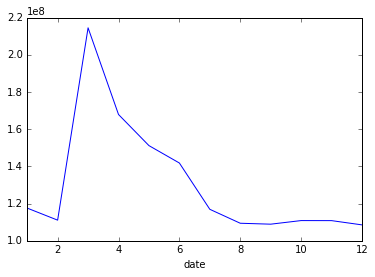

In [61]:
transactions.groupby(transactions['date'].map(lambda x: x.month)).purchaseamount.sum().plot()

### Summary Statistics for Train + Offers Table

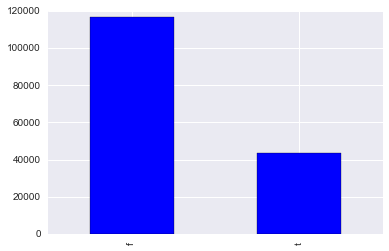

In [157]:
#Graph of non-repeaters vs repeaters
train.repeater.value_counts().plot(kind='bar')

In [65]:
scatter_matrix(train, alpha=0.2, figsize=(6, 6), diagonal='kde')

NameError: name 'scatter_matrix' is not defined

## Model Building

### Logistic Regression

In [66]:
# Create Validation set
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(train_X, train_Y, test_size=0.2, random_state=42)

In [80]:
# List to store Results and Compare
results = {}

In [68]:
#Train on full set
from sklearn.linear_model import LogisticRegressionCV

log = LogisticRegressionCV(cv = 5)

log.fit(train_X,train_Y)
y_pred_log = log.predict_proba(test_X)

In [70]:
#Train Validation set
from sklearn.linear_model import LogisticRegressionCV

log = LogisticRegressionCV(cv = 5)

log.fit(X_train,Y_train)
y_log = log.predict_proba(X_test)

In [35]:
log.get_params

<bound method LogisticRegressionCV.get_params of LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)>

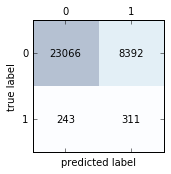

In [74]:
confmat = metrics.confusion_matrix(log.predict(X_test),Y_test)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()

In [76]:
print metrics.classification_report(log.predict(X_test),Y_test)

             precision    recall  f1-score   support

          0       0.99      0.73      0.84     31458
          1       0.04      0.56      0.07       554

avg / total       0.97      0.73      0.83     32012



In [90]:
results['LogisiticRegression'] = metrics.roc_auc_score(log.predict(X_test),Y_test)
print metrics.roc_auc_score(log.predict(X_test),Y_test)

0.647301725778


In [37]:
#create repeat probability list
y_prob = []
for n in y_pred_log:
    
    y_prob.append(n[1])

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

forest = RandomForestClassifier()

param_grid = {"max_depth": [3, None],
              "max_features": ['auto', 'sqrt', 'log2'],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
             "n_estimators" : [50,100,150]}

gs = GridSearchCV(estimator=forest,param_grid=param_grid, cv=3,n_jobs=-1)

gs.fit(train_X,train_Y)

In [ ]:
gs.best_params_

y_pred_forest = gs.predict_proba(test_X)

In [40]:
forest.score(train_X,train_Y)

0.99998750445153917

In [173]:
#create repeat probability list
y_prob = []
for n in y_pred_forest:
    
    y_prob.append(n[1])

### Extra Trees Classfier

In [85]:
# Train on full set
from sklearn.ensemble import ExtraTreesClassifier

extratrees = ExtraTreesClassifier(n_estimators=1000, n_jobs=-1)

extratrees.fit(train_X,train_Y)

y_pred_extra = extratrees.predict_proba(test_X)

In [89]:
#Train on Validation Set
from sklearn.ensemble import ExtraTreesClassifier

extratrees = ExtraTreesClassifier(n_estimators=1000, n_jobs=-1)

extratrees.fit(X_train,Y_train)

y_extra = extratrees.predict_proba(X_test)

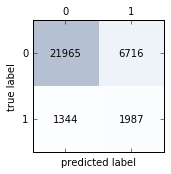

In [97]:
confmat = metrics.confusion_matrix(extratrees.predict(X_test),Y_test)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()

In [92]:
results['ExtraTreesClassifier'] = metrics.roc_auc_score(extratrees.predict(X_test),Y_test)
print metrics.roc_auc_score(extratrees.predict(X_test),Y_test)

0.68117778676


In [86]:
#create repeat probability list
y_prob = []
for n in y_pred_extra:
    
    y_prob.append(n[1])

### XGBoost Classifier

In [186]:
xgb.XGBClassifier?

In [ ]:
import xgboost as xgb
clf = xgb.XGBoostClassifier(
        eval_metric = 'auc',
        num_class = 2,
        nthread = -1,
        silent = 1,
        )
param_grid = {'num_boost_round': [100, 300, 500],
        'eta': [0.05, 0.1, 0.3],
        'max_depth': [3,6, 9, 12],
        'subsample': [0.7,0.8,0.9, 1.0],
        'colsample_bytree': [0.7,0.8,0.9, 1.0],
          }
xgbcv = GridSearchCV(clf, parameters, n_jobs=-1, cv=5)
    
xgbcv.fit(train_X,train_Y)

In [ ]:
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
    print('score:', score)
    for param_name in sorted(best_parameters.keys()):
        print("%s: %r" % (param_name, best_parameters[param_name]))
    print('predicted:', clf.predict([[1,1]]))

In [93]:
# Train on fullset
import xgboost as xgb
clf = xgb.XGBClassifier(n_estimators=300,
                        nthread=-1,
                        max_depth=3,
                        learning_rate=0.1,
                        silent=True,
                        subsample=0.8,
                        colsample_bytree=0.8)
                        
xgb_model = clf.fit(train_X,train_Y)
predict_xgb = xgb_model.predict_proba(test_X)

In [108]:
# Train on validation set
import xgboost as xgb
clf = xgb.XGBClassifier(n_estimators=300,
                        nthread=-1,
                        max_depth=3,
                        learning_rate=0.1,
                        silent=True,
                        subsample=0.8,
                        colsample_bytree=0.8)
                        
xgb_model = clf.fit(X_train,Y_train)
Y_xgb = xgb_model.predict_proba(X_test)

In [110]:
results['XGboost'] = metrics.roc_auc_score(xgb_model.predict(X_test),Y_test)
print metrics.roc_auc_score(xgb_model.predict(X_test),Y_test)

0.709702237806


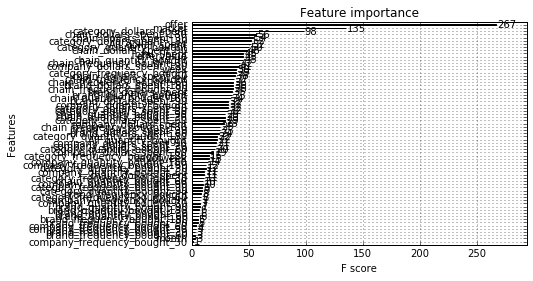

In [102]:
xgb.plot_importance(xgb_model)

In [199]:
xgb_model.score(train_X,train_Y)

0.76224095166097083

In [94]:
#create repeat probability list
y_prob = []
for n in predict_xgb:
    
    y_prob.append(n[1])

In [ ]:
### Ensemble Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_validation.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

## Create Submission File

In [95]:
submit = pd.DataFrame({'id' : ids, 'repeatProbability' : y_prob}).set_index('id')
submit.to_csv("submission.csv")